<a href="https://colab.research.google.com/github/anushree825/speech_proj/blob/main/SSP_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install noisereduce

In [ ]:
import os
import scipy
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt 
import noisereduce as nr
import audioread
import IPython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

path = "/content/drive/MyDrive/ssp/temp.mp3"


In [ ]:
def time_scale_mod(filename,dur):
  y, sr   = librosa.load(str(filename))
  D       = librosa.stft(y, n_fft=2048)
  D_fast  = librosa.phase_vocoder(D, dur)
  y_fast  = librosa.istft(D_fast)
  return y_fast,sr
y,sr = time_scale_mod(path,2)
IPython.display.Audio(data=y, rate=sr) 

In [ ]:
def pitch_scaling(filename,steps):
  y, sr = librosa.load(str(filename))
  y_third = librosa.effects.pitch_shift(y, sr, n_steps=steps)
  return y_third,sr
y,sr = pitch_scaling(path,2)
IPython.display.Audio(data=y, rate=sr)   

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


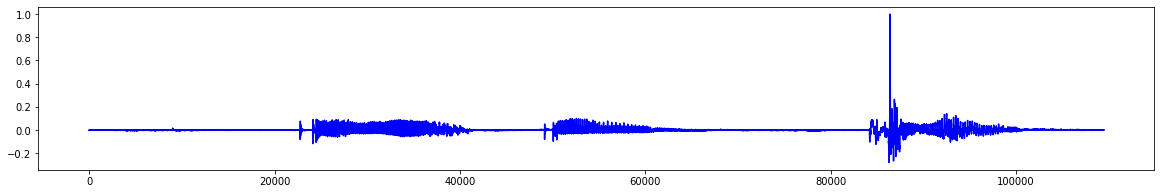

In [ ]:
def amplitude_scaling(filename):
  Fs,data=wavfile.read(str(filename))
  max_amp = max(data)
  data = data/max_amp
  fig, ax = plt.subplots(figsize=(20,3))
  ax.plot(data,color='blue')
  #plt.show(data)
amplitude_scaling(path)
 


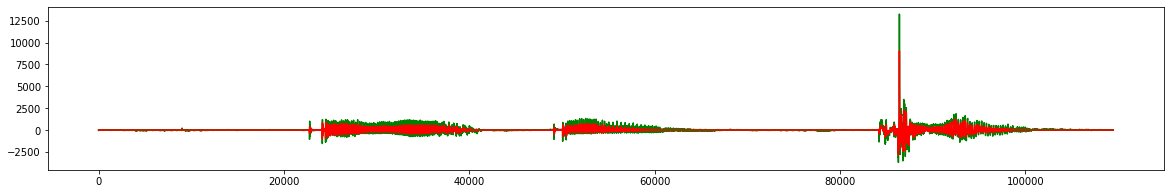

In [ ]:
def noise_reduction(filename):
  Fs,data=wavfile.read(str(filename))
  reduced_noise = nr.reduce_noise(y=data, sr=Fs)
  fig, ax = plt.subplots(figsize=(20,3))
  ax.plot(data,color='green')
  ax.plot(reduced_noise,color='red')
noise_reduction(path)

In [ ]:

def framing(filename,window='hann',frameLength=20,shiftFrame=25):
    fs,signal = wavfile.read(str(filename))
    #type(signal)
    sigLen=len(list(signal))
  
    outFrames=[]
    N=int(frameLength*fs/1000)
    Nshift=int(shiftFrame*fs/1000)
    window=scipy.signal.hann(N)

    numFrames=int(np.floor((sigLen-N)/Nshift) +1 )
    print(numFrames)
    for i in range(0,numFrames):
        sigSlice=signal[N*i:(i+1)*N]
        # frame=np.dot(window,sigSlice)
        frame = map(lambda x,y: x*y, window, sigSlice)
        outFrames.append(list(frame))
    return(outFrames, fs)
x,y = framing(path)
print(x)    

99
[[-0.0, -0.00020345392396592388, -0.0008646681817062185, -0.002174340080838, -0.00569634768529137, -0.006039423954855294, -0.008696365006554685, -0.007475410610701783, -0.009763180825175244, -0.012355635336234627, -0.010168428188412904, -0.015378378593726705, -0.009149878579513548, -0.03006433127590802, -0.037353768985259606, -0.03715861987529023, -0.0032517458389521026, -0.018352013241324794, -0.028800131560327125, -0.07333486146588619, -0.09139953214741658, -0.03358348919208942, -0.07370269987636635, 0.0, -0.014613015238255533, -0.03963210443893722, -0.05142817638950792, -0.12937820485145157, 0.0198723993145421, -0.11721627850683419, -0.1140074071828967, -0.1825546196536973, -0.16854094337345055, -0.16540608285637304, -0.5265980341436949, -0.5578665777670127, -0.7211383532370164, -0.5711415713002629, -0.6204892589473516, -0.4611972318954609, -0.525404695167839, -0.8064967373342374, -0.8237560136700162, -1.0031062820875132, -0.9278336611332938, -0.9956500061646949, -0.7466601129129